# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import vae
from loguru import logger
import numpy as np
import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [2]:
# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset2D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset2D(testfileVAE, target="target", outliersRemoval=True)
validationSetVAE = datasets.HeartDataset2D(validationfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()
validdationstreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()

Training the Autoencoder is really hard, because it could reconstruct a lot of abnormal samples with a reconstruction loss as small as with the normal samples.
Therefore some comparison is made

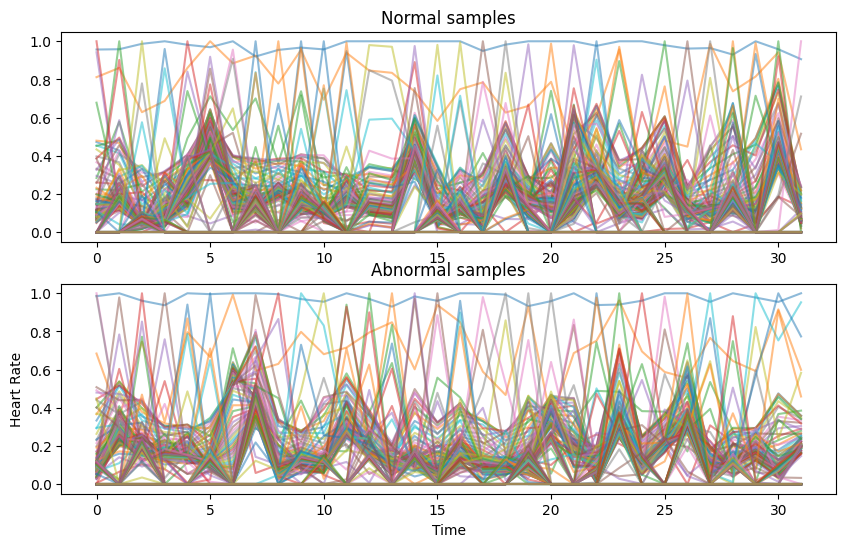

In [3]:
import matplotlib.pyplot as plt

# Initialize a plot
fig = plt.figure(figsize=(10, 6))

XN, X2 = next(trainstreamerVAE)
XA, X2 = next(validdationstreamerVAE)

XN = XN.view(XN.size(0), -1) 
XA = XA.view(XA.size(0), -1) 

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(XN, alpha=0.5)
ax1.set_title('Normal samples')

ax2.plot(XA, alpha=0.5)
ax2.set_title('Abnormal samples')


plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show plot
plt.show()

In [4]:
gin.parse_config_file(Path('../src/config.gin').resolve())

X1, X2 = next(trainstreamerVAE)

encoder = vae.Encoder()
decoder = vae.Decoder()

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = vae.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")
autoencoder = vae.AutoEncoder()

settings = TrainerSettings(
    epochs=200,
    metrics=[lossfn],
    logdir="logs",
    train_steps=200,
    valid_steps=200,
    reporttypes=[ReportTypes.TENSORBOARD],
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 8,
    },
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2024-06-21 17:08:57.238 | INFO     | __main__:<module>:9 - the latent shape : torch.Size([32, 1])
2024-06-21 17:08:57.257 | INFO     | __main__:<module>:12 - the shape after: torch.Size([32, 1, 16, 12])
2024-06-21 17:08:57.258 | INFO     | __main__:<module>:16 - Untrained loss: 7.4621500968933105
2024-06-21 17:08:57.260 | INFO     | __main__:<module>:18 - starting training for 200 epochs
2024-06-21 17:08:57.265 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240621-170857
2024-06-21 17:08:57.589 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 200/200 [00:03<00:00, 66.28it/s]
2024-06-21 17:09:01.631 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.3457 test 0.0253 metric ['0.0253']
100%|██████████| 200/200 [00:03<00:00, 63.59it/s]
2024-06-21 17:09:05.802 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2392 test 0.0207 metric ['0.0207']
100%|████████

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import vae

autoencoder.eval()  # Set the model to evaluation mode
reconstruction_losses = []
targets = []

validation_loader = DataLoader(validationSetVAE, batch_size=1, shuffle=False)

with torch.no_grad():
    for X, y in tqdm(validation_loader, colour="#1e4706"):
        yhat = autoencoder(X)
        # X = X.view(X.size(0), -1)  # Flatten the input if necessary

        # Compute reconstruction loss for each item in the batch
        loss = lossfn(X, yhat).cpu().numpy()  # Convert loss to numpy array
        
        # Append each individual loss and target to the lists
        reconstruction_losses.append(loss)
        targets.extend(y.cpu().numpy())
        


100%|██████████| 2911/2911 [00:04<00:00, 674.79it/s]


((2105, 2), (0, 2), (0, 2), (806, 2))

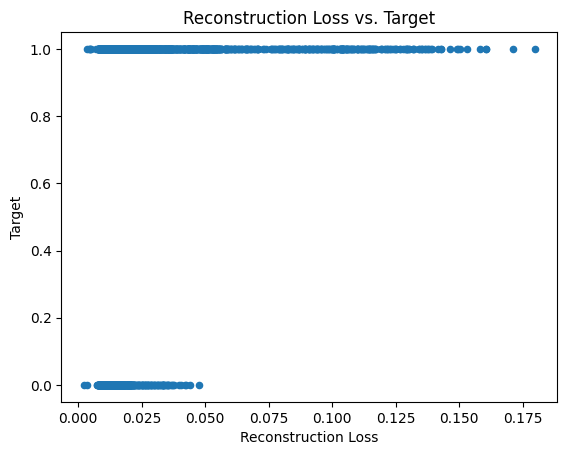

In [8]:
data = {
        'Reconstruction Loss': reconstruction_losses,
        'Target': targets
    }

# Create DataFrame for easy plotting
df = pd.DataFrame(data)
# print(df.head())

# Plot using Seaborn
df.plot.scatter(x='Reconstruction Loss', y='Target')
plt.title('Reconstruction Loss vs. Target')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Target')

threshold = 8
(
    df[(df['Target'] == 1) & (df['Reconstruction Loss'] <= threshold)].shape, #Abnormal <= threshold #bad recall
    df[(df['Target'] == 1) & (df['Reconstruction Loss'] > threshold)].shape, #Abnormal > threshold #good recall
    df[(df['Target'] == 0) & (df['Reconstruction Loss'] > threshold)].shape, #Normal > threshold  # good recall
    df[(df['Target'] == 0) & (df['Reconstruction Loss'] <= threshold)].shape #Normal <= threshold #good recall
) 


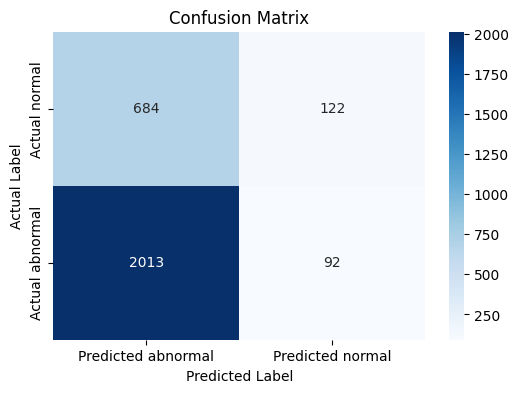

In [15]:
# Calculate confusion matrix
threshold = 0.01
fn = df[(df['Target'] == 1) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # false negative (Abnormal <= threshold)
tp = df[(df['Target'] == 1) & (df['Reconstruction Loss'] > threshold)].shape[0]   # true positive (Abnormal > threshold)
fp = df[(df['Target'] == 0) & (df['Reconstruction Loss'] > threshold)].shape[0]   # false positive (Normal > threshold)
tn = df[(df['Target'] == 0) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # true negative (Normal <= threshold)

# Confusion matrix data
confusion_matrix = [
    [fp, tn],  # Actual Positive (Abnormal)
    [tp, fn]   # Actual Negative (Normal)
]

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted abnormal', 'Predicted normal'],
            yticklabels=['Actual normal', 'Actual abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


After trying and changing layers and tweaking paramaters for days, I give up!
The autoencoder, sees a lot of abnormal heart rates as normal heart rates as shown in the above figures.
I squeezed the latent space to the most narrow variant and still no luck. I think to make it work, some way of penalizing the model for making reconstruction errors hard by abnormal heart rates.
Probably this could be done, by making it a supervised learning algorithm and using the actual label for penalizing the model harder.

Taking time in consideration, I quit this way and take another one.

Because of all the hours I put in this piece of art, I still keep the code (maybe for the next generation) and reference to it in the paper.
Maybe it will work some day.